#                                     Stroke Prediction - Don't be fooled by big numbers

This notebook presents a comprehensive machine learning analysis focused on the prediction of stroke, a critical medical event with devastating consequences. A stroke occurs when blood flow to a part of the brain is interrupted or reduced, depriving brain tissue of oxygen and nutrients. Globally, stroke is a leading cause of death and a major contributor to long-term disability, with millions affected each year. The application of machine learning in healthcare holds significant promise for early risk identification and personalized patient care.

The primary objective is to develop a predictive model, but equally important is to address the inherent challenges of real-world medical data. This project specifically highlights the issue of class imbalance, a phenomenon where one class (e.g., patients with a stroke) is vastly underrepresented. Through a series of methodical evaluations, we will illustrate why conventional metrics like accuracy can be highly misleading in such contexts. By titling this notebook "Don't Be Fooled by Big Numbers," I emphasize the need for a nuanced and responsible approach to model assessment, prioritizing clinical utility over superficial performance metrics.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/brain-stroke-dataset/brain_stroke.csv


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})
os.makedirs("../figures", exist_ok=True)  


/kaggle/input/brain-stroke-dataset/brain_stroke.csv


## 1 - EDA

**Starting with some data inspection**

Shape: (4981, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


None

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,4981,4981.000000,4981.000000,4981.000000,4981,4981,4981,4981.000000,4981.000000,4981,4981.000000
unique,2,NaN,NaN,NaN,2,4,2,NaN,NaN,4,NaN
top,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,2907,NaN,NaN,NaN,3280,2860,2532,NaN,NaN,1838,NaN
mean,NaN,43.419859,0.096165,0.055210,NaN,NaN,NaN,105.943562,28.498173,NaN,0.049789
std,NaN,22.662755,0.294848,0.228412,NaN,NaN,NaN,45.075373,6.790464,NaN,0.217531
min,NaN,0.080000,0.000000,0.000000,NaN,NaN,NaN,55.120000,14.000000,NaN,0.000000
25%,NaN,25.000000,0.000000,0.000000,NaN,NaN,NaN,77.230000,23.700000,NaN,0.000000
50%,NaN,45.000000,0.000000,0.000000,NaN,NaN,NaN,91.850000,28.100000,NaN,0.000000
75%,NaN,61.000000,0.000000,0.000000,NaN,NaN,NaN,113.860000,32.600000,NaN,0.000000


0    4733
1     248
Name: stroke, dtype: int64
Proportions (%) :
0    95.02
1     4.98
Name: stroke, dtype: float64


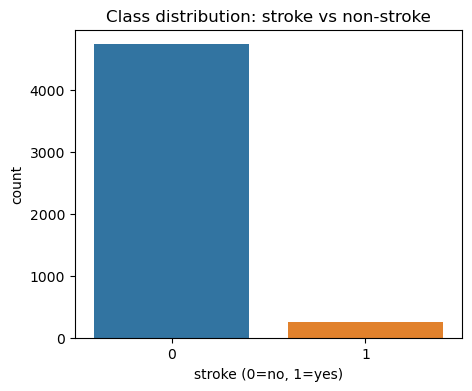

In [3]:
df=pd.read_csv('/kaggle/input/brain-stroke-dataset/brain_stroke.csv')
# Dataset Overview
print("Shape:", df.shape)
display(df.head())
display(df.info())
display(df.describe(include='all'))

# Proportions stroke / non-stroke
counts = df['stroke'].value_counts()
print(counts)
print("Proportions (%) :")
print((counts / counts.sum() * 100).round(2))

# Barplot classe
plt.figure(figsize=(5,4))
sns.countplot(x='stroke', data=df)
plt.title('Class distribution: stroke vs non-stroke')
plt.xlabel('stroke (0=no, 1=yes)')
plt.ylabel('count')
plt.savefig("../figures/class_distribution.png", bbox_inches='tight')
plt.show()


**Let's check whether there is any NaN**

In [4]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

None ! Great, nothing to do here.

**A look at some distribution**

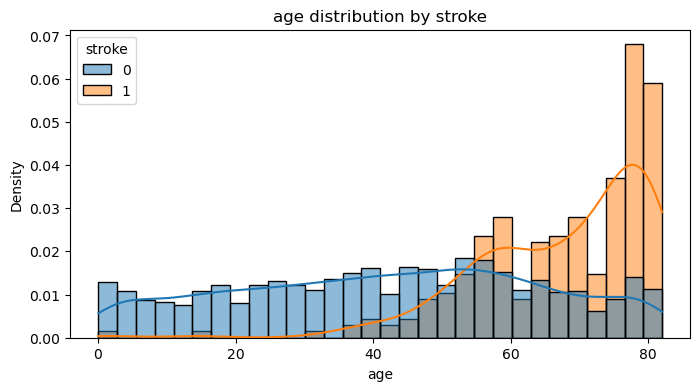

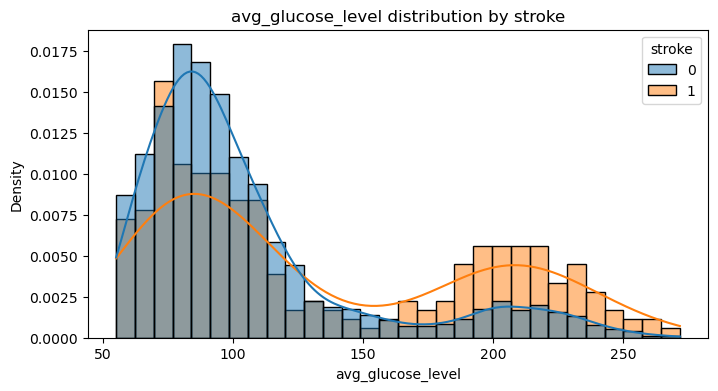

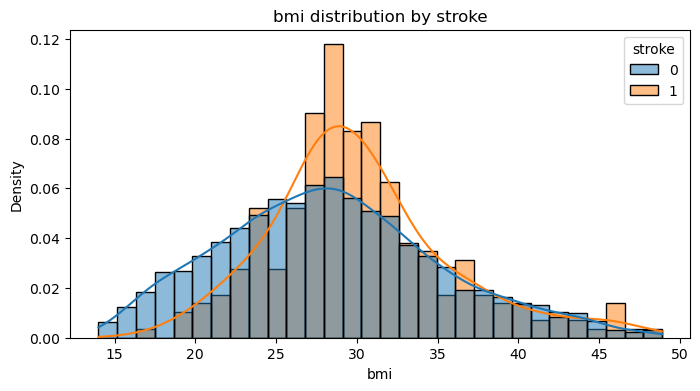

In [5]:
num_cols = ['age','avg_glucose_level','bmi']   # adapte si noms différents

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(data=df, x=col, hue='stroke', kde=True, stat="density", common_norm=False, bins=30)
    plt.title(f'{col} distribution by stroke')
    plt.savefig(f"../figures/{col}_by_stroke.png", bbox_inches='tight')
    plt.show()


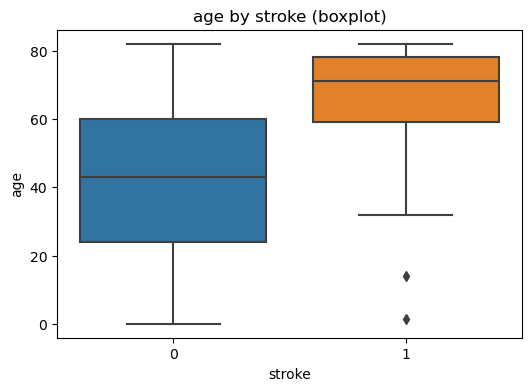

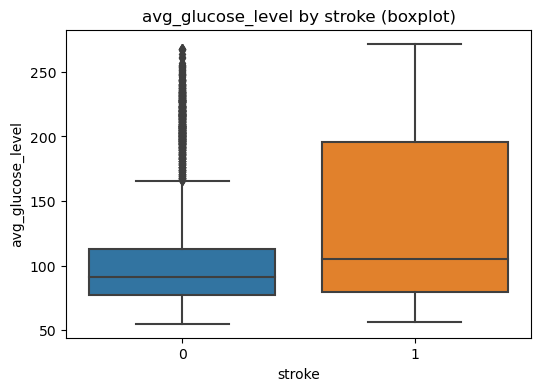

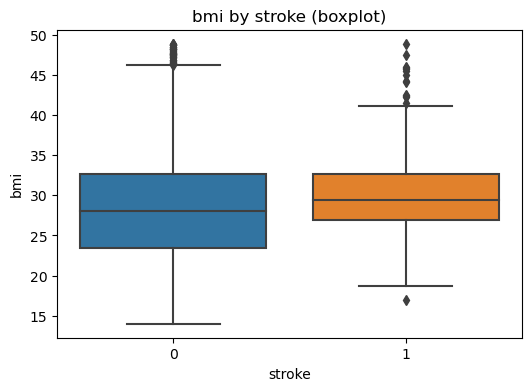

In [6]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='stroke', y=col, data=df)
    plt.title(f'{col} by stroke (boxplot)')
    plt.savefig(f"../figures/{col}_boxplot.png", bbox_inches='tight')
    plt.show()


# More on Data Viz

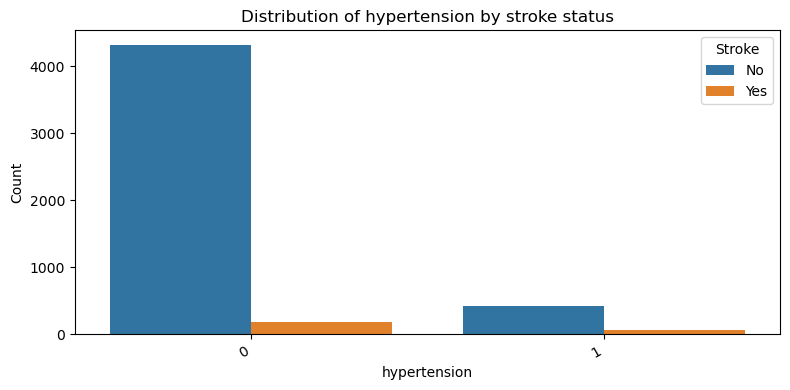

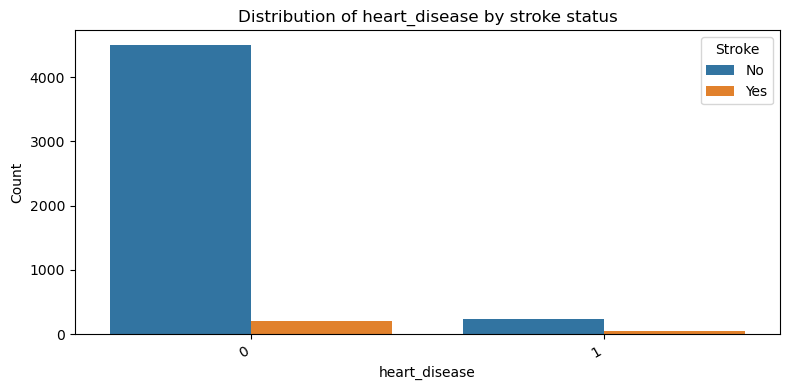

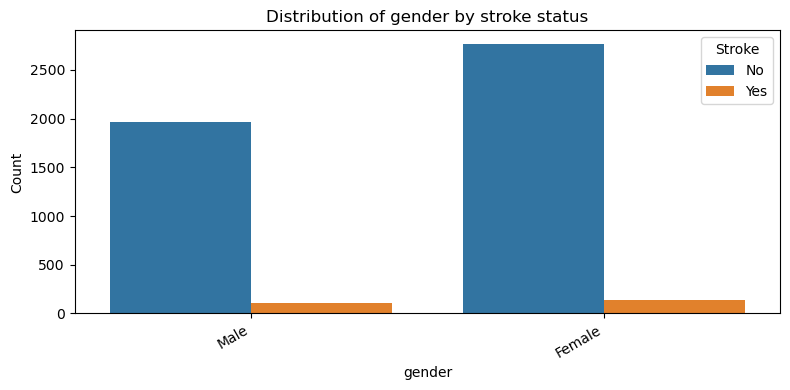

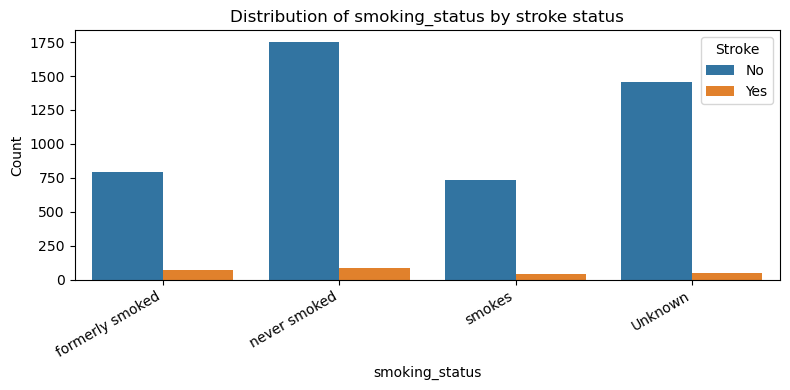

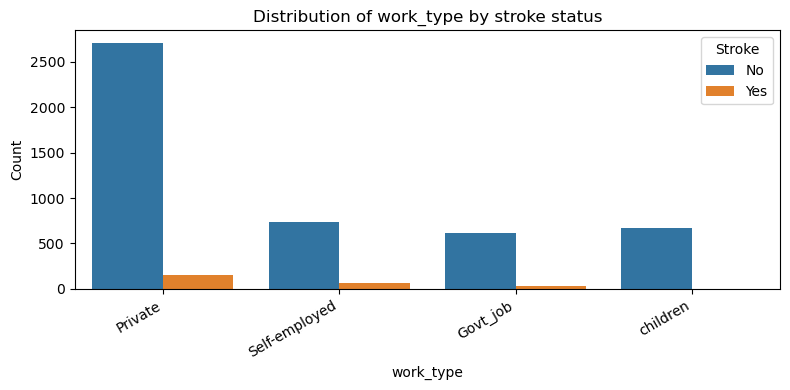

In [7]:
cat_cols = ['hypertension','heart_disease','gender','smoking_status','work_type'] 

for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, hue='stroke')
    plt.title(f'Distribution of {col} by stroke status')
    plt.xticks(rotation=30, ha='right')
    plt.ylabel("Count")
    plt.legend(title='Stroke', labels=['No','Yes'])
    plt.tight_layout()
    plt.show()


**Another way to look at those variables : what is the proportion of strokes for each category?** 

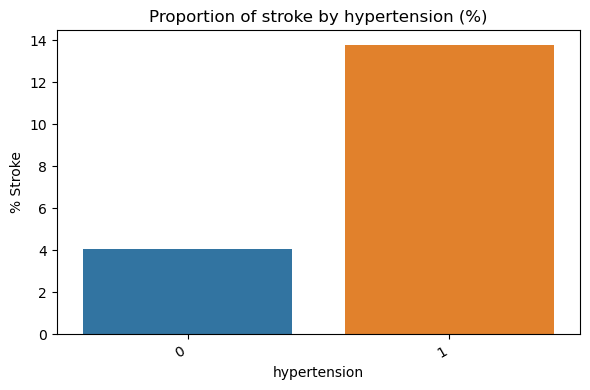

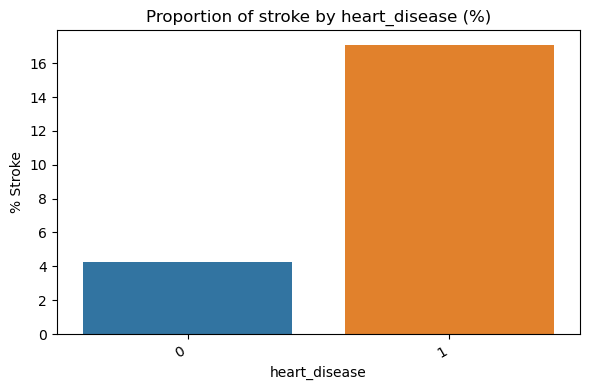

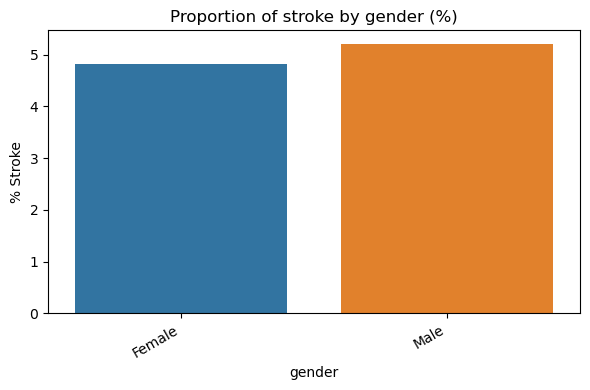

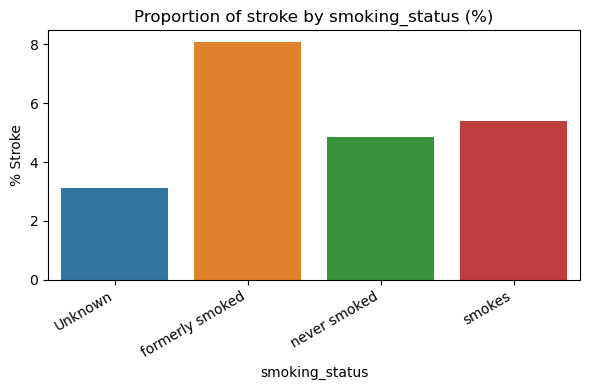

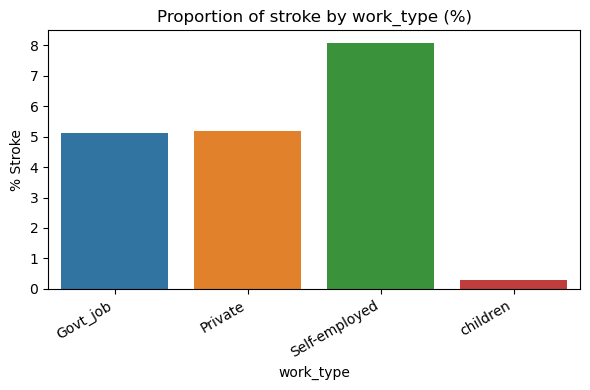

In [8]:
for col in cat_cols:
    prop = df.groupby(col)['stroke'].mean() * 100
    plt.figure(figsize=(6,4))
    sns.barplot(x=prop.index, y=prop.values)
    plt.title(f'Proportion of stroke by {col} (%)')
    plt.ylabel('% Stroke')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()


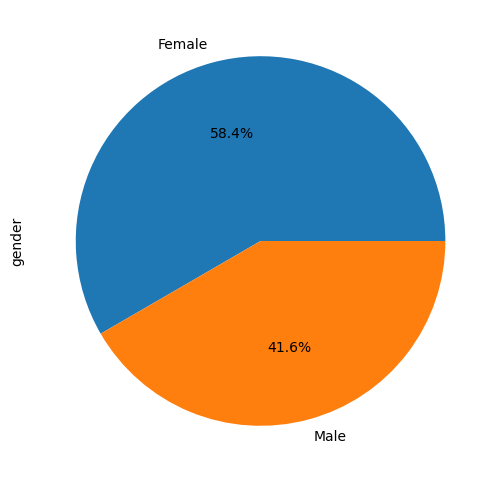

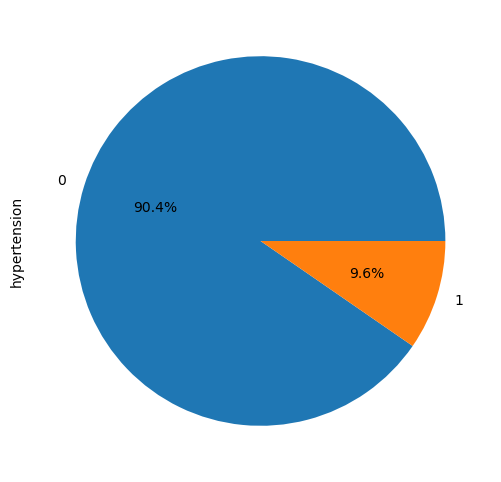

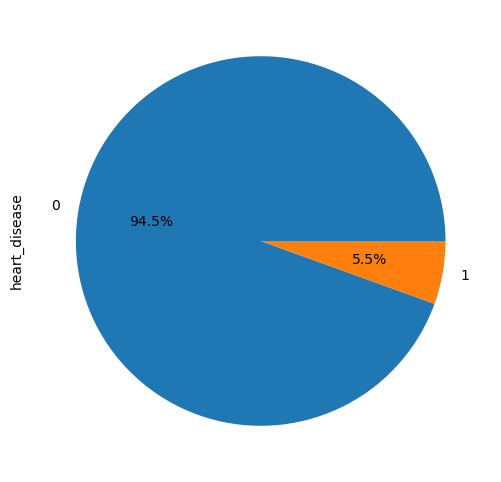

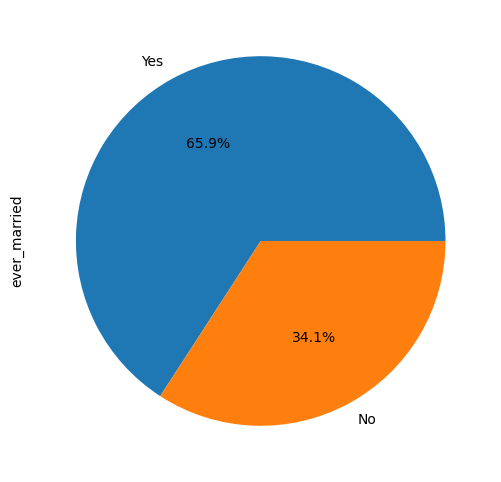

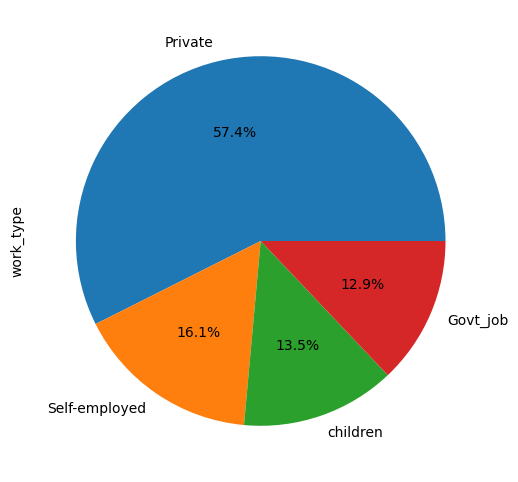

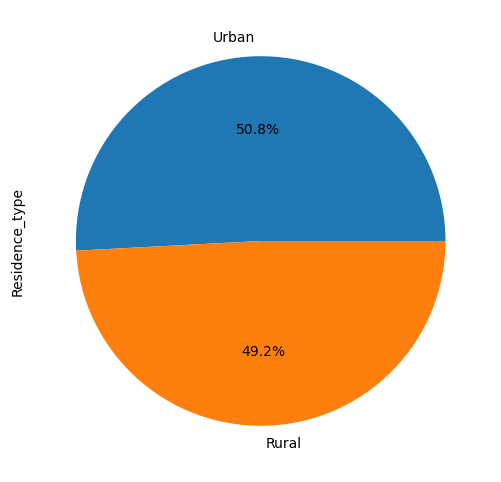

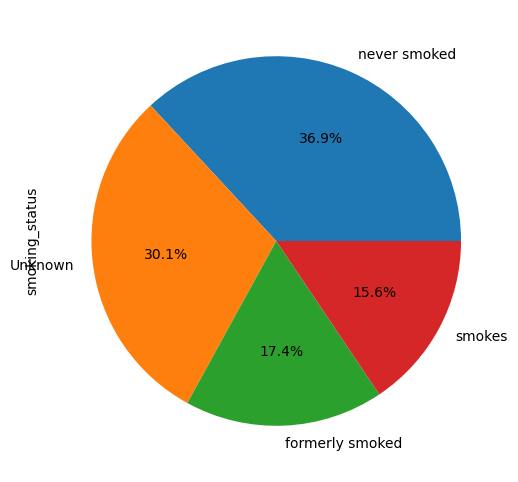

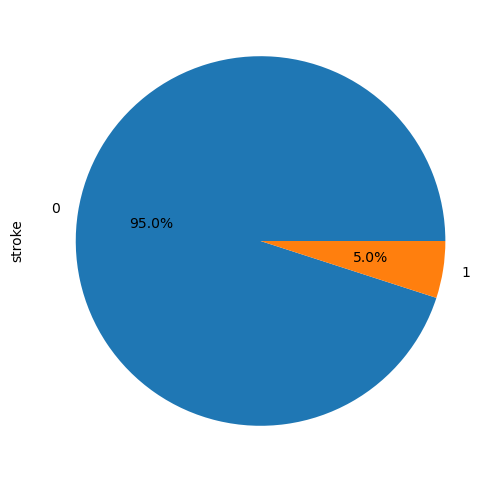

In [9]:
data_categorical = df[['gender', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 
                 'smoking_status', 'stroke']]

for i in data_categorical.columns:
    plt.figure(figsize = (15,6))
    data_categorical[i].value_counts().plot(kind = 'pie', autopct = '%1.1f%%')
    plt.xticks(rotation = 90)
    plt.show()

In [10]:

#Percentage of strokes by modality
for col in cat_cols:
    prop = df.groupby(col)['stroke'].mean().sort_values(ascending=False)
    print(f"\nProportion of stroke by {col}:")
    display((prop*100).round(2))


num_df = df.select_dtypes(include=[np.number]).copy()
display(num_df.groupby(df['stroke']).mean().T)


Proportion of stroke by hypertension:


hypertension
1    13.78
0     4.04
Name: stroke, dtype: float64


Proportion of stroke by heart_disease:


heart_disease
1    17.09
0     4.27
Name: stroke, dtype: float64


Proportion of stroke by gender:


gender
Male      5.21
Female    4.82
Name: stroke, dtype: float64


Proportion of stroke by smoking_status:


smoking_status
formerly smoked    8.07
smokes             5.41
never smoked       4.84
Unknown            3.13
Name: stroke, dtype: float64


Proportion of stroke by work_type:


work_type
Self-employed    8.08
Private          5.17
Govt_job         5.12
children         0.30
Name: stroke, dtype: float64

stroke,0,1
age,42.141348,67.819839
hypertension,0.087260,0.266129
heart_disease,0.048172,0.189516
avg_glucose_level,104.569056,132.175565
bmi,28.409698,30.186694
stroke,0.000000,1.000000


**For a quick initial analysis, we can also take a look at the correlation matrix.**

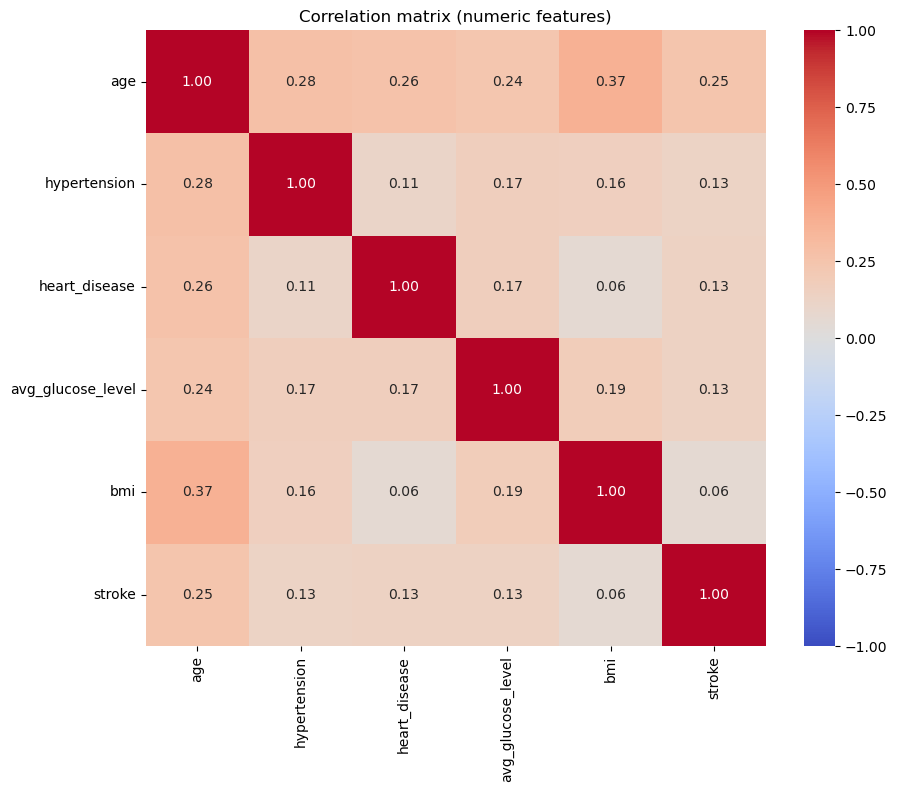

In [11]:
plt.figure(figsize=(10,8))
corr = num_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix (numeric features)")
plt.savefig("../figures/correlation_matrix.png", bbox_inches='tight')
plt.show()

We can also look at some rough correlations

/tmp/ipykernel_20/177197511.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


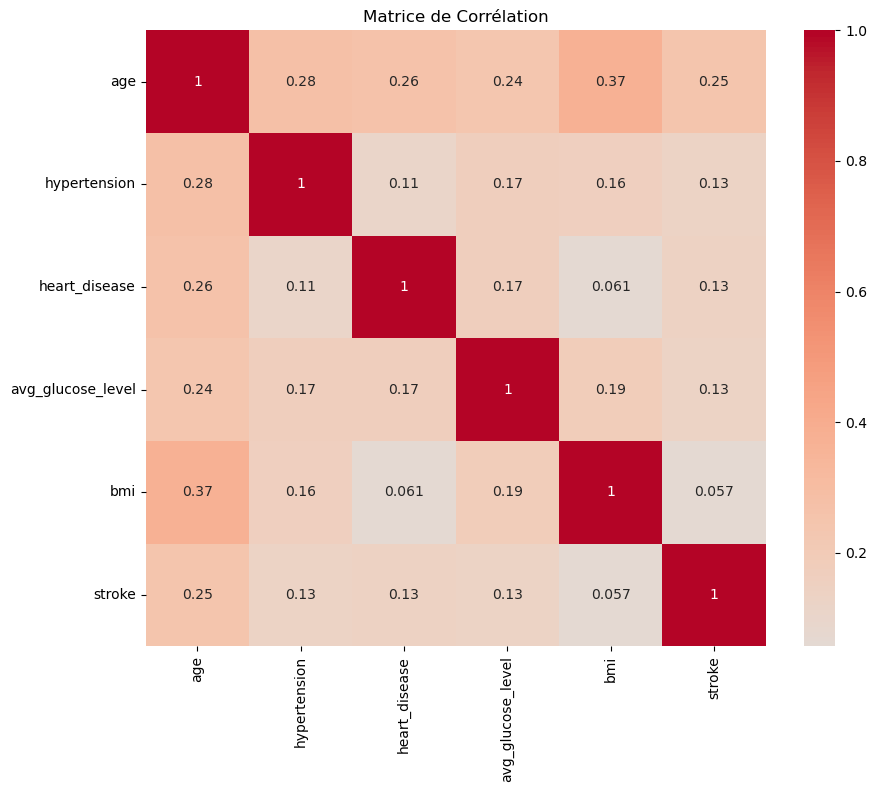

In [12]:
correlation_matrix = df.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de Corrélation')
plt.show()

Our target variable 'stroke' seems to have its highest correlation with the age 'column'